# Open Exploration 1: Scenario without policy

... [add NB description] ...

**Open Exploration Goals**

* 

**Notebook Outline**
1. [Model and Dependency Import](#1-model-and-dependency-import)  
2. [Dike Model Simulation](#2-dike-model-simulation)  
3. [Global Sensitivity Analysis](#3-global-sensitivity-analysis)  
4. [Scenario Discovery](#4-scenario-discovery)

## 1. Model and dependency import

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## 2. Simulation

Sampling in the scenario (uncertainty) space: 20000 scenarios 1 policy

Systematically vary uncertain factors while keeping policy levers fixed, to analyze their impact on disaggregated outcomes (problem formulation 6).

In [2]:
######## Problem Formulation
pf = 6
n_scenario = 20000
n_policy = 1

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Reference Policy (No Levers)
ref_policy = [Policy('policy 1', **{'0_RfR 0':0,
                                    '1_RfR 0':0,
                                    '2_RfR 0':0,
                                    '3_RfR 0':0,
                                    '4_RfR 0':0,
                                    '0_RfR 1':0,
                                    '1_RfR 1':0,
                                    '2_RfR 1':0,
                                    '3_RfR 1':0,
                                    '4_RfR 1':0,
                                    'A.1_DikeIncrease 0':0,
                                    'A.2_DikeIncrease 0':0,
                                    'A.3_DikeIncrease 0':0,
                                    'A.4_DikeIncrease 0':0,
                                    'A.5_DikeIncrease 0':0,
                                    'A.1_DikeIncrease 1':0,
                                    'A.2_DikeIncrease 1':0,
                                    'A.3_DikeIncrease 1':0,
                                    'A.4_DikeIncrease 1':0,
                                    'A.5_DikeIncrease 1':0,
                                    'EWS_DaysToThreat':0})
                                ]

######## Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenario, policies=ref_policy, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf, n_scenario, n_policy))

[MainProcess/INFO] pool started with 6 workers
[MainProcess/INFO] performing 20000 scenarios * 1 policies * 1 model(s) = 20000 experiments
100%|████████████████████████████████████| 20000/20000 [07:02<00:00, 47.34it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S20000_P1_.tar.gz


## 3. Global Sensitivity Analysis

### 3.1 Feature Scoring of Scenario Space

In [11]:
######## Problem Formulation
pf, n_scenario, n_policy = 6, 20000, 1 

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Load results
results = load_results('results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf, n_scenario, n_policy))
experiments, outcomes = results

######## drop levers
experiments.drop(columns=list(model.levers.keys()), inplace=True)

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S20000_P1_.tar.gz


In [4]:
experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,scenario,policy,model
0,127,202.901518,1.0,0.566565,252.935944,10.0,0.744913,180.563339,1.5,0.647645,...,10.0,0.945906,144.323646,1.5,0.348390,2.5,4.5,0,policy 1,dikesnet
1,2,249.683895,10.0,0.909774,237.977090,10.0,0.173040,35.436793,1.5,0.934137,...,10.0,0.735142,280.583770,10.0,0.154618,1.5,2.5,1,policy 1,dikesnet
2,35,227.127666,10.0,0.987519,299.615537,10.0,0.041570,266.061600,1.0,0.129042,...,1.0,0.734556,219.549106,1.5,0.459981,3.5,4.5,2,policy 1,dikesnet
3,27,334.664377,1.0,0.130184,166.762808,1.0,0.732096,96.036839,1.5,0.690613,...,10.0,0.642581,141.809429,10.0,0.182522,1.5,3.5,3,policy 1,dikesnet
4,73,147.965822,1.0,0.869478,74.963002,1.5,0.701927,70.187151,1.0,0.983110,...,10.0,0.699540,274.531049,1.0,0.187413,4.5,2.5,4,policy 1,dikesnet


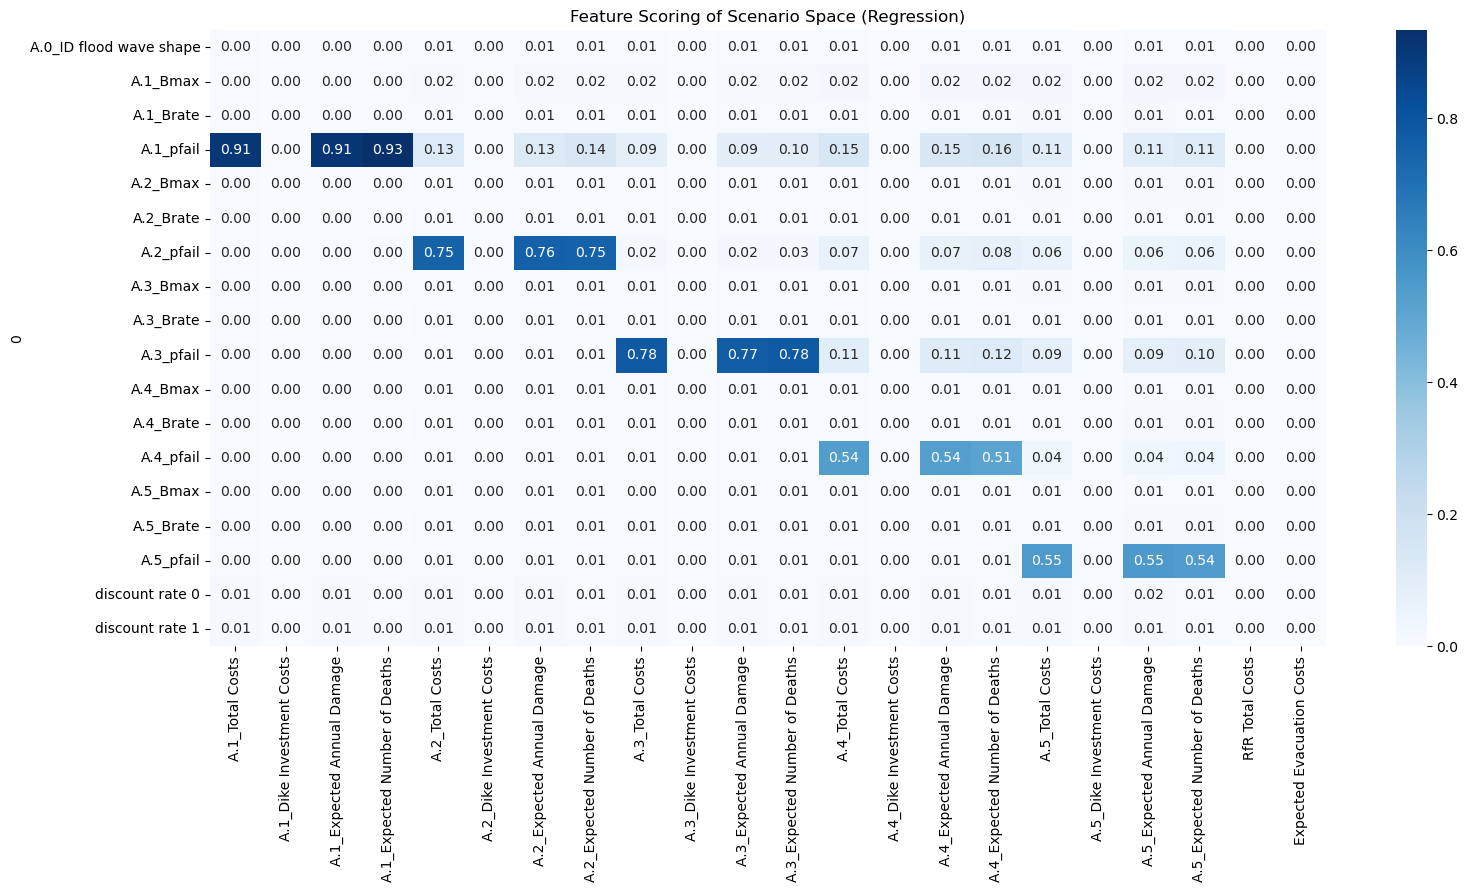

In [5]:
import matplotlib.pyplot as plt

scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
plt.figure(figsize=(18, 8))
ax = sns.heatmap(scores, annot=True, cmap = "Blues", fmt=".2f")
ax.set_title("Feature Scoring of Scenario Space (Regression)")
plt.show()

## 4. Scenario Discovery

In [13]:
experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,scenario,policy,model
0,127,202.901518,1.0,0.566565,252.935944,10.0,0.744913,180.563339,1.5,0.647645,...,10.0,0.945906,144.323646,1.5,0.348390,2.5,4.5,0,policy 1,dikesnet
1,2,249.683895,10.0,0.909774,237.977090,10.0,0.173040,35.436793,1.5,0.934137,...,10.0,0.735142,280.583770,10.0,0.154618,1.5,2.5,1,policy 1,dikesnet
2,35,227.127666,10.0,0.987519,299.615537,10.0,0.041570,266.061600,1.0,0.129042,...,1.0,0.734556,219.549106,1.5,0.459981,3.5,4.5,2,policy 1,dikesnet
3,27,334.664377,1.0,0.130184,166.762808,1.0,0.732096,96.036839,1.5,0.690613,...,10.0,0.642581,141.809429,10.0,0.182522,1.5,3.5,3,policy 1,dikesnet
4,73,147.965822,1.0,0.869478,74.963002,1.5,0.701927,70.187151,1.0,0.983110,...,10.0,0.699540,274.531049,1.0,0.187413,4.5,2.5,4,policy 1,dikesnet


In [10]:
experiments.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'scenario', 'policy', 'model'],
      dtype='object')

In [15]:
outcomes.keys()

dict_keys(['A.1_Total Costs', 'A.1_Dike Investment Costs', 'A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 'A.2_Total Costs', 'A.2_Dike Investment Costs', 'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths', 'A.3_Total Costs', 'A.3_Dike Investment Costs', 'A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'A.4_Total Costs', 'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 'A.5_Total Costs', 'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [30]:
for outcome in model.outcomes:
    print(outcome.name)

A.1_Total Costs
A.1_Dike Investment Costs
A.1_Expected Annual Damage
A.1_Expected Number of Deaths
A.2_Total Costs
A.2_Dike Investment Costs
A.2_Expected Annual Damage
A.2_Expected Number of Deaths
A.3_Total Costs
A.3_Dike Investment Costs
A.3_Expected Annual Damage
A.3_Expected Number of Deaths
A.4_Total Costs
A.4_Dike Investment Costs
A.4_Expected Annual Damage
A.4_Expected Number of Deaths
A.5_Total Costs
A.5_Dike Investment Costs
A.5_Expected Annual Damage
A.5_Expected Number of Deaths
RfR Total Costs
Expected Evacuation Costs


### Histogram of outcomes

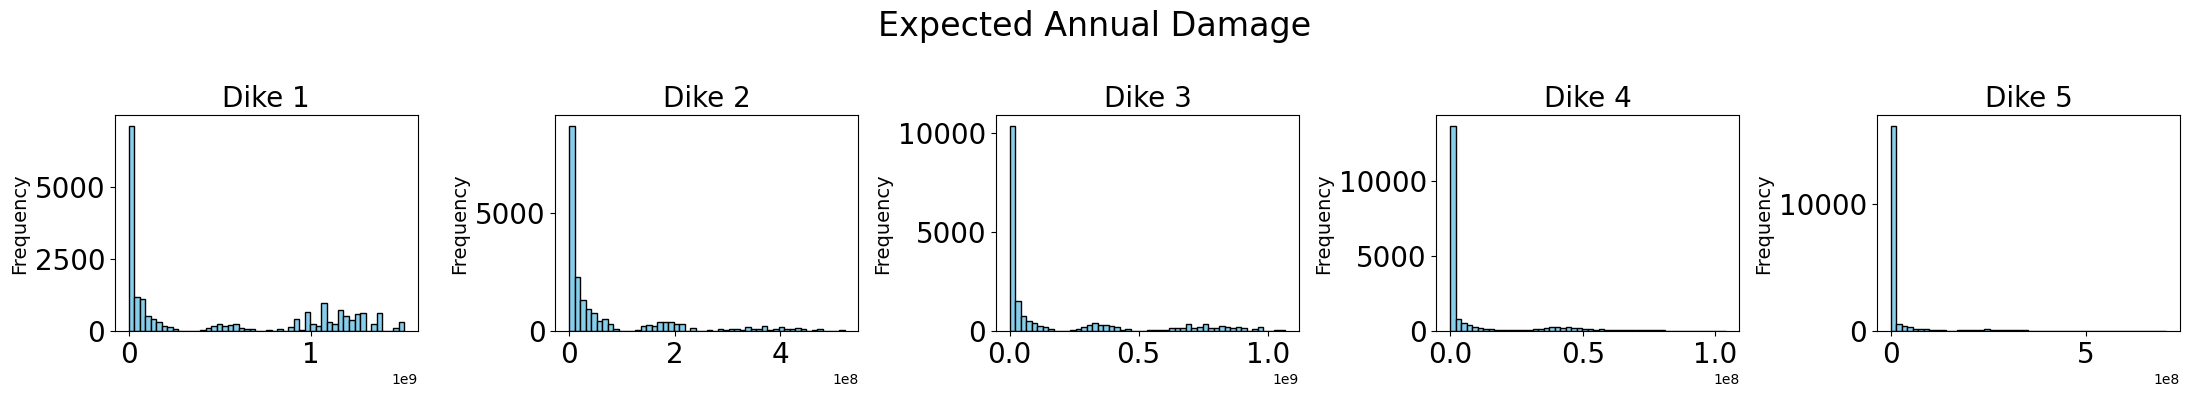

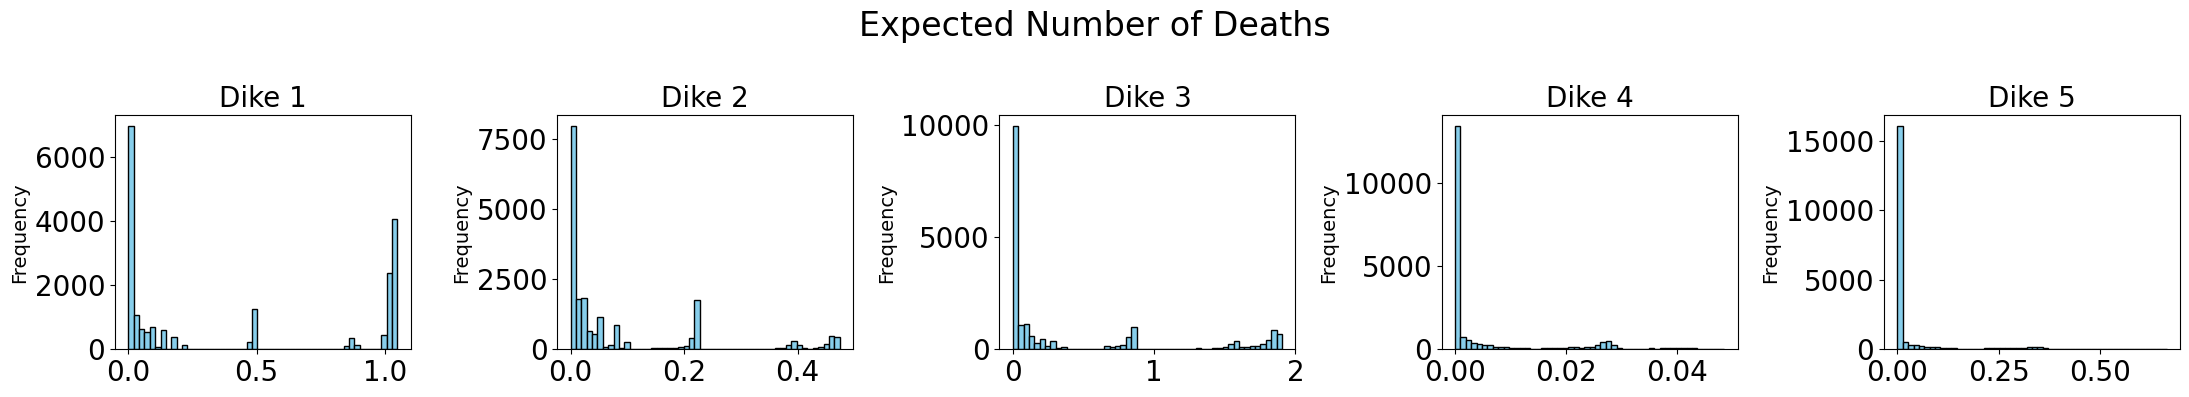

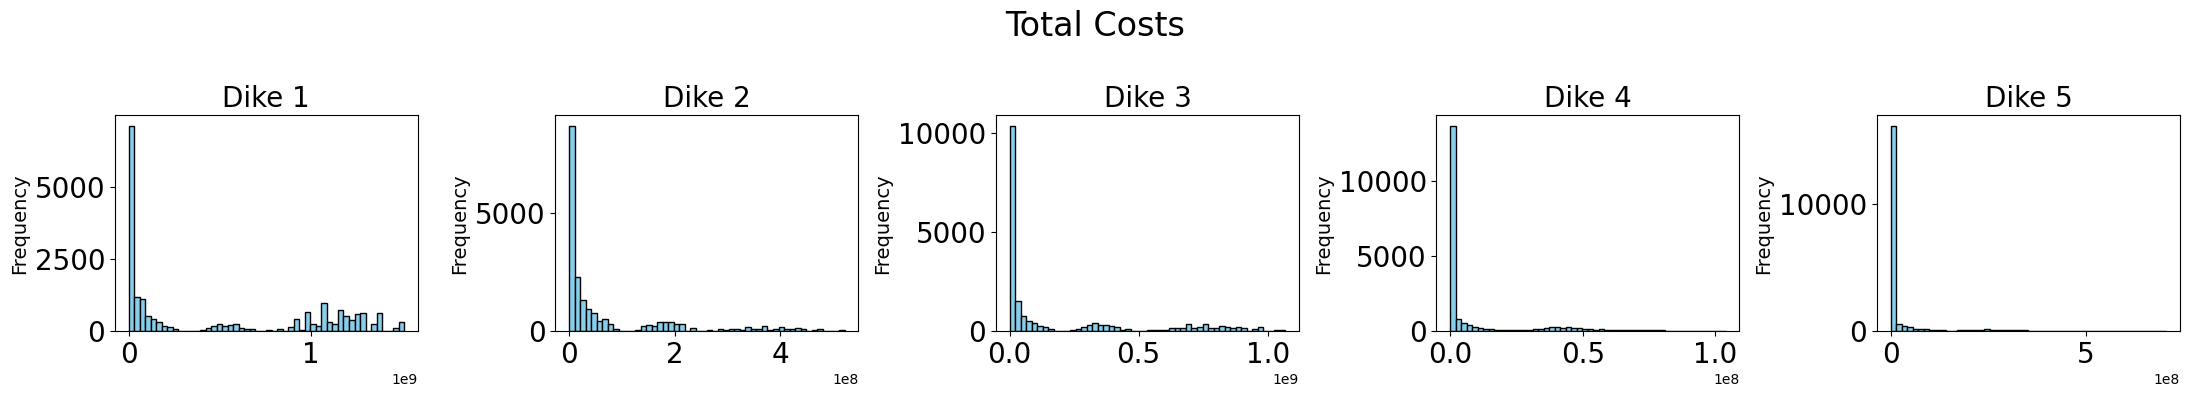

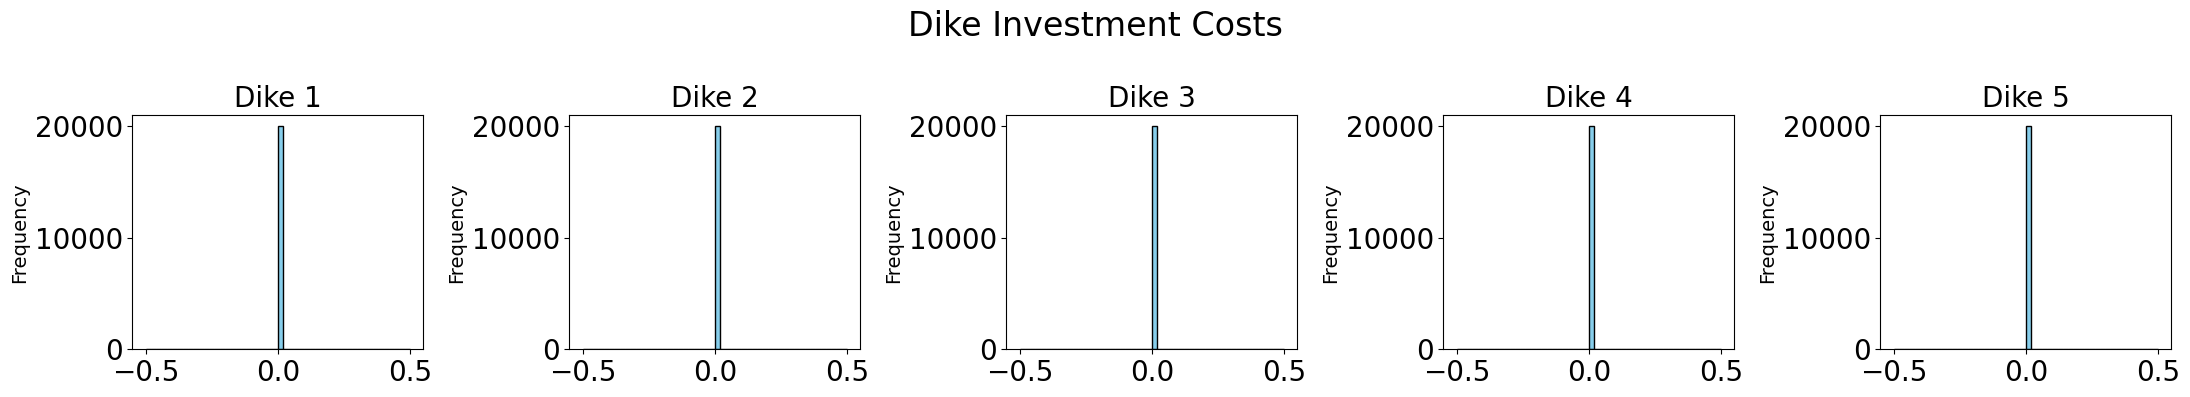

In [112]:
disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs", "Dike Investment Costs"]

# Plot histograms for each disaggregated outcome for all dikes with larger font size
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(22, 4))
    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes[key], bins=50, color='skyblue', edgecolor='black')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        #axes[i].set_xlabel(outcome_name, fontsize=14)
        axes[i].set_ylabel("Frequency", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

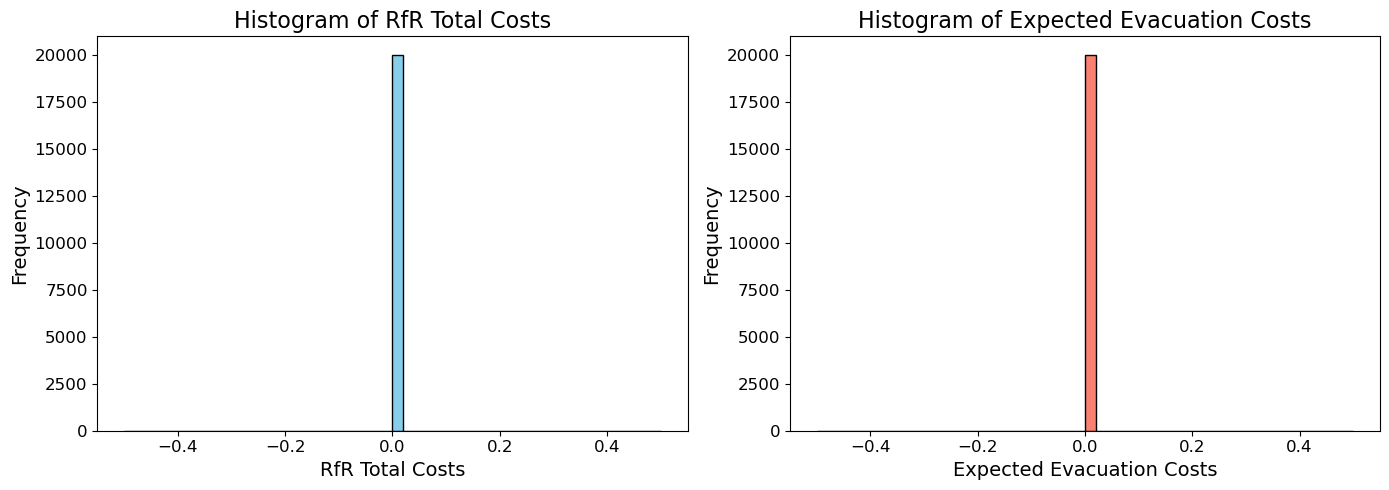

In [110]:
# Plot histograms for RfR Total Costs and Expected Evacuation Costs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(outcomes['RfR Total Costs'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of RfR Total Costs', fontsize=16)
axes[0].set_xlabel('RfR Total Costs', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

axes[1].hist(outcomes['Expected Evacuation Costs'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Expected Evacuation Costs', fontsize=16)
axes[1].set_xlabel('Expected Evacuation Costs', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

### Discover worst case scenarios

Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability

In [154]:
from ema_workbench.analysis import prim

data = outcomes['A.5_Expected Number of Deaths']

y = data > np.percentile(data, 10)

prim_alg = prim.Prim(experiments, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category


[MainProcess/INFO] 20000 points remaining, containing 4961 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06225, coverage: 0.2509574682523685, density: 1.0 restricted_dimensions: 5


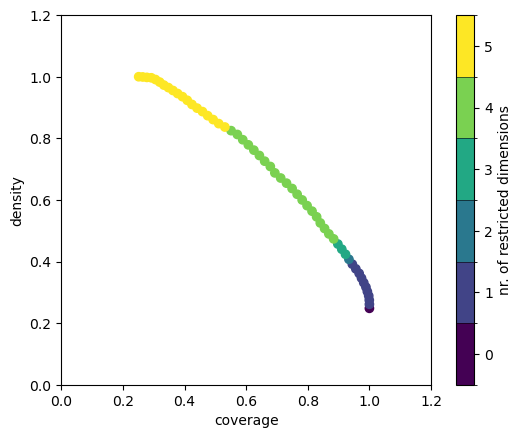

In [155]:
box1.show_tradeoff()
plt.show()

[<Figure size 640x480 with 1 Axes>]

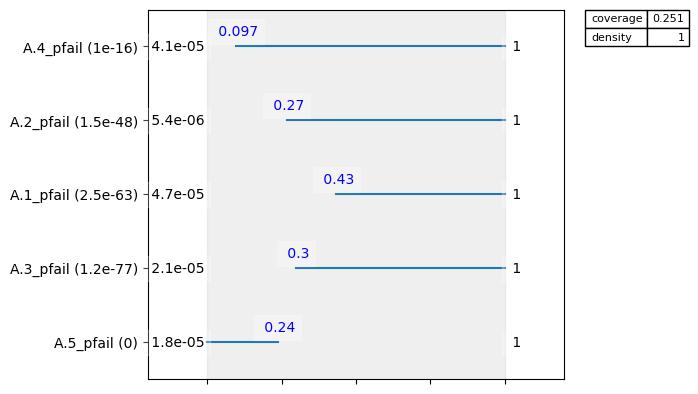

In [156]:
box1.inspect(style='graph')

In [157]:
box1.inspect(style='table')

coverage       0.250957
density        1.000000
id            54.000000
k           1245.000000
mass           0.062250
mean           1.000000
n           1245.000000
res_dim        5.000000
Name: 54, dtype: float64

             box 54                                 
                min       max      qp value qp value
A.5_pfail  0.000018  0.236413           NaN      0.0
A.3_pfail  0.298766  0.999951  1.238741e-77      NaN
A.1_pfail  0.433790  0.999978  2.464537e-63      NaN
A.2_pfail  0.266995  0.999957  1.487484e-48      NaN
A.4_pfail  0.096680  0.999957  1.032089e-16      NaN



[None]

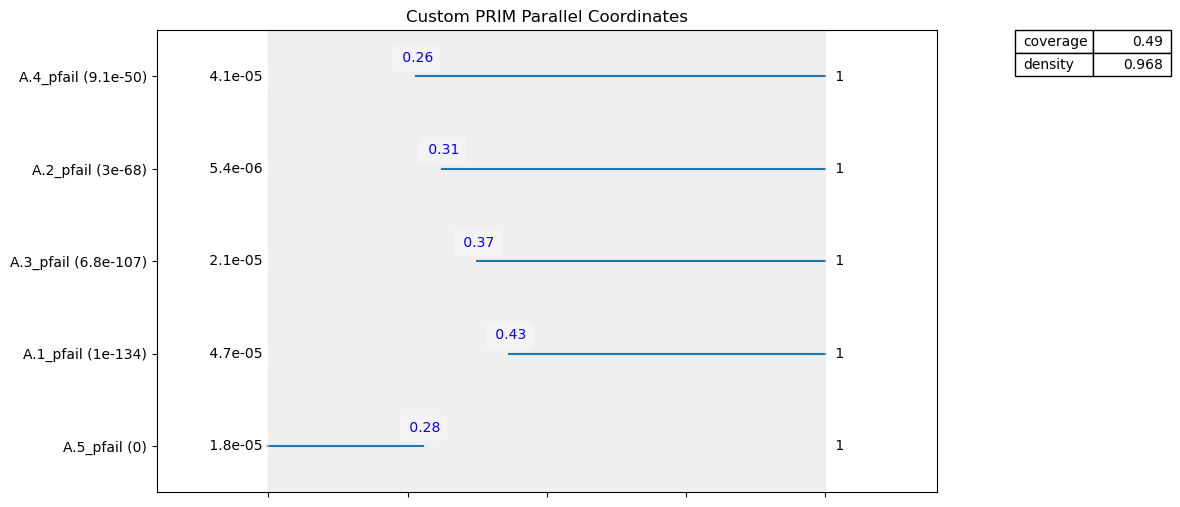

In [153]:
fig, ax = plt.subplots(figsize=(12, 6))
box1.inspect(style='graph', ax=ax)
ax.set_title("Custom PRIM Parallel Coordinates")

# Example: set y-axis limits (for density/coverage, if shown)
#ax.set_xlim(0, 1)

plt.show()

In [116]:
box1.inspect(style='table')

coverage       0.489745
density        0.968348
id            58.000000
k            979.000000
mass           0.050550
mean           0.968348
n           1011.000000
res_dim        5.000000
Name: 58, dtype: float64

             box 58                                  
                min       max       qp value qp value
A.5_pfail  0.000018  0.277538            NaN      0.0
A.1_pfail  0.431838  0.999978  1.045941e-134      NaN
A.3_pfail  0.374701  0.999951  6.796378e-107      NaN
A.2_pfail  0.311407  0.999957   3.029001e-68      NaN
A.4_pfail  0.264577  0.999957   9.101993e-50      NaN



[None]

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category


[MainProcess/INFO] 20000 points remaining, containing 16095 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.735, coverage: 0.9133271202236719, density: 1.0 restricted_dimensions: 1
[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 20000 points remaining, containing 14508 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.3582, coverage: 0.49379652605459057, density: 1.0 restricted_dimensions: 2
[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 20000 points remaining, containing 12094 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1744, coverage: 0.2884074747808831, density: 1.0 restricted_dimensions: 3
[MainProcess/INFO] column policy dropped from analysis because it has only one c

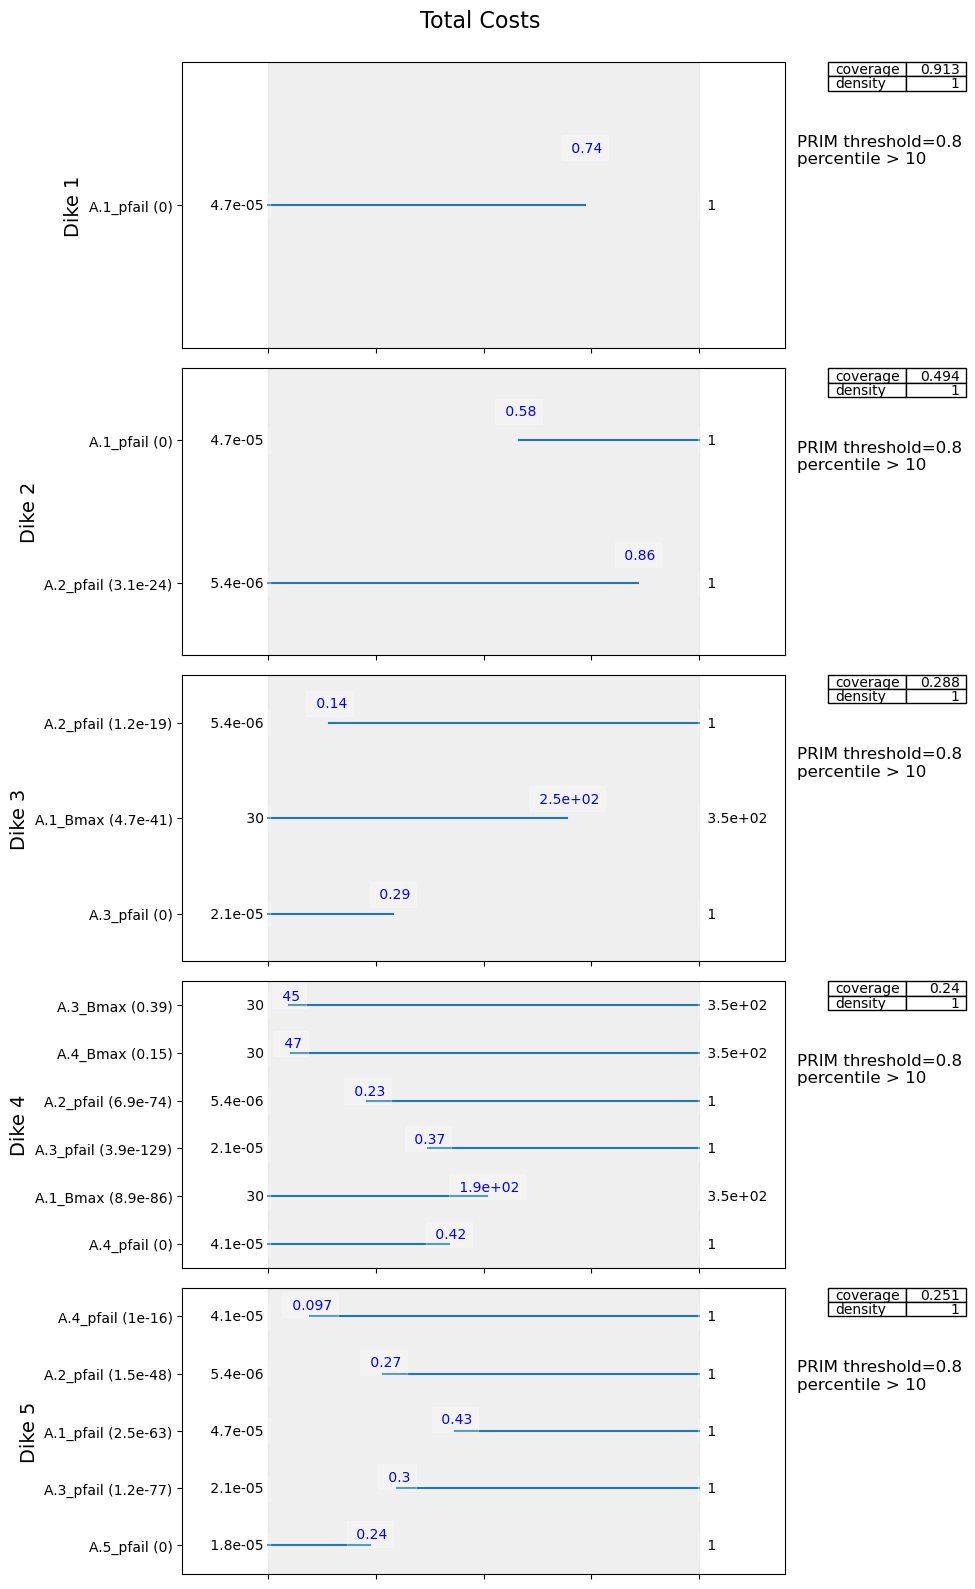

In [162]:
## show all result: Expected Number of Deaths

from ema_workbench.analysis import prim

# plot detail
outcome_name_ = 'Total Costs'
dike_percentiles = [10, 10, 10, 10, 10]  # Percentiles for each dike
# Specify a threshold for each dike (can be customized as needed)
dike_thresholds = [0.8, 0.8, 0.8, 0.8, 0.8]

fig, axes = plt.subplots(5, 1, figsize=(10, 16))

for i, dike_no in enumerate(range(1, 6)):
    outcome_name = f"A.{dike_no}_{outcome_name_}"
    data = outcomes[outcome_name]
    y = data > np.percentile(data, dike_percentiles[dike_no - 1])
    prim_alg = prim.Prim(experiments, y, threshold=dike_thresholds[dike_no - 1])
    box = prim_alg.find_box()
    box.inspect(style='graph', ax=axes[i])
    if i == 0:
        axes[i].set_title(f"{outcome_name_} \n", fontsize=16)
    axes[i].set_ylabel(f"Dike {dike_no}", fontsize=14)
    # Shift annotation to the right outside the graph
    axes[i].annotate(
        f"PRIM threshold={dike_thresholds[dike_no - 1]}\npercentile {'> ' if y.sum() > 0 else '< '}{dike_percentiles[dike_no - 1]}",
        xy=(1.02, 0.75), xycoords='axes fraction',
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

plt.tight_layout()
plt.show()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 20000 points remaining, containing 10000 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.43985, coverage: 0.8797, density: 1.0 restricted_dimensions: 1


Results for A.1_Expected Annual Damage:


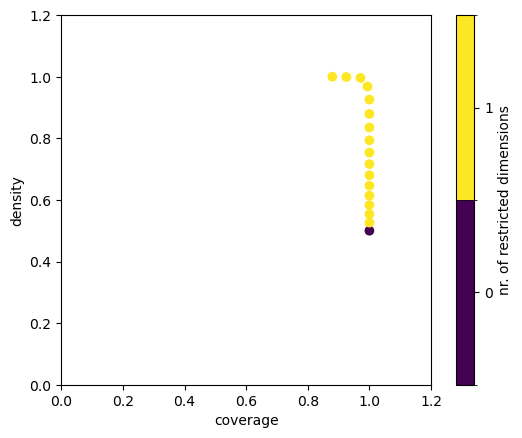

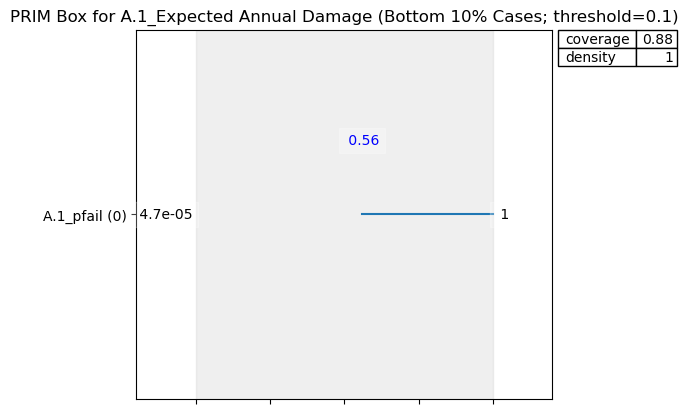

In [96]:
## show all result: Expected Annual Damage

from ema_workbench.analysis import prim

# Specify a threshold for each dike (can be customized as needed)
dike_thresholds = [0.1, 0.8, 0.8, 0.8, 0.8]
dike_percentiles = [50, 20, 30, 40, 50]  # Percentiles for each dike

for dike_no in range(1, 6):
    outcome_name = f"A.{dike_no}_Expected Annual Damage"
    data = outcomes[outcome_name]
    threshold_value = np.percentile(data, dike_percentiles[dike_no - 1])
    y = data < threshold_value
    if np.sum(y) == 0:
        print(f"Warning: No cases found below the 10th percentile for {outcome_name} (threshold={threshold_value}). Skipping PRIM.")
        continue
    prim_alg = prim.Prim(experiments, y, threshold=dike_thresholds[dike_no - 1])
    box = prim_alg.find_box()
    print(f"Results for {outcome_name}:")
    box.show_tradeoff()
    box.inspect(style='graph')
    plt.title(f"PRIM Box for {outcome_name} (Bottom 10% Cases; threshold={dike_thresholds[dike_no - 1]})")
    plt.show()

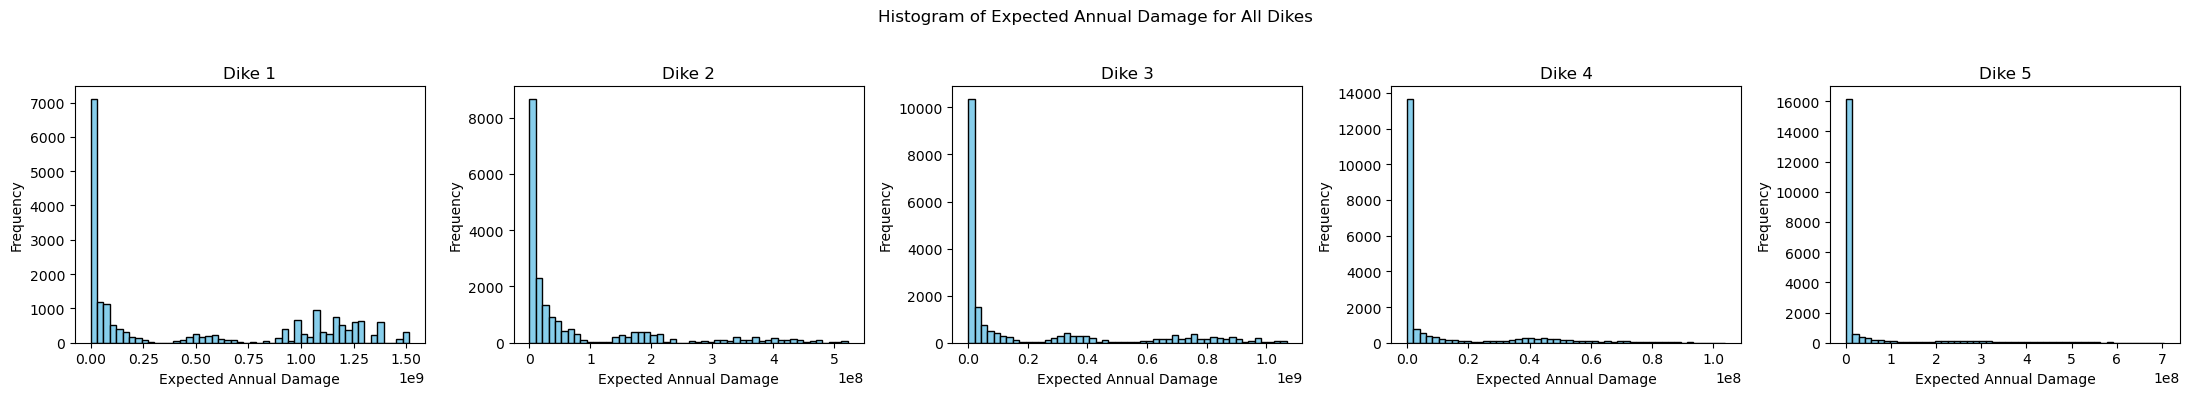